<a href="https://colab.research.google.com/github/rodrigorenemenegazzo/Artificial-Intelligence/blob/main/GAN_CelebFaces_Attributes_(CelebA)_Dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import zipfile
import pandas as pd
import os
import numpy as np

from matplotlib import pyplot as plt

from tqdm import tqdm
from PIL import Image as Img
from keras import Input
from keras.layers import Dense, Reshape, LeakyReLU, Conv2D, Conv2DTranspose, Flatten, Dropout
from keras.models import Model
from tensorflow.keras.optimizers import RMSprop

In [2]:
from google.colab import drive
drive.mount('/content/drive')

dataset_path = "/content/drive/MyDrive/Especializacao IA UFPR/IAA009 - Frameworks de IA/archive.zip.zip"


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# descompactar a base
zip_object = zipfile.ZipFile(file=dataset_path, mode="r")
zip_object.extractall("./")
zip_object.close()

In [4]:
#Listar arquivos 
#!ls img_align_celeba/img_align_celeba

Img shape:  (218, 178, 3)


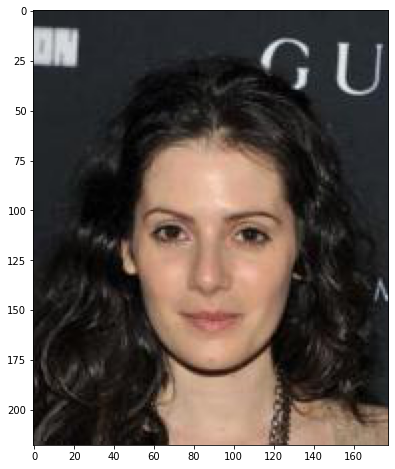

In [5]:
#Testar abrir uma imagem e plotar
img = np.array(Img.open('img_align_celeba/img_align_celeba/138835.jpg'))
plt.figure(figsize=(8,8))
plt.imshow(img)
#print(img)
print('Img shape: ',img.shape)

Importando os dados e redimensionando as imagens

In [6]:

#PIC_DIR = f'../img_align_celeba/img_align_celeba/'
PIC_DIR = "img_align_celeba/img_align_celeba/"

IMAGES_COUNT = 10000

ORIG_WIDTH = 178
ORIG_HEIGHT = 208
diff = (ORIG_HEIGHT - ORIG_WIDTH) // 2

WIDTH = 128
HEIGHT = 128

crop_rect = (0, diff, ORIG_WIDTH, ORIG_HEIGHT - diff)

images = []
for pic_file in tqdm(os.listdir(PIC_DIR)[:IMAGES_COUNT]):
    pic = Img.open(PIC_DIR + pic_file).crop(crop_rect)
    pic.thumbnail((WIDTH, HEIGHT), Img.ANTIALIAS)
    images.append(np.uint8(pic))

100%|██████████| 10000/10000 [00:15<00:00, 628.76it/s]


In [7]:
#Image shape
images = np.array(images) / 255
print(images.shape)

(10000, 128, 128, 3)


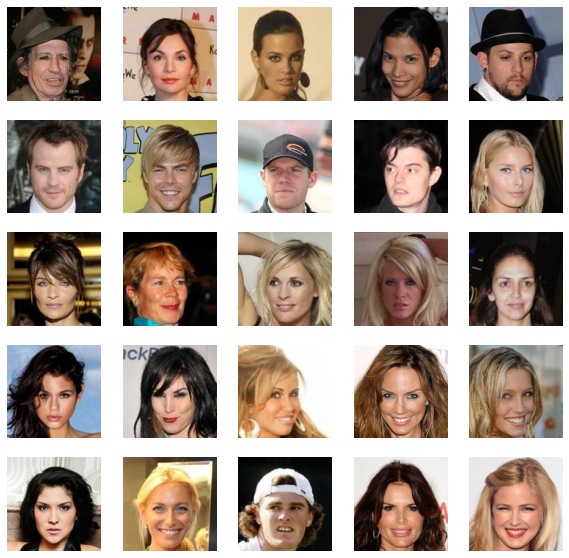

In [8]:
#Display first 25 images
plt.figure(1, figsize=(10, 10))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.imshow(images[i])
    plt.axis('off')
plt.show()

Criando o generator

In [9]:
LATENT_DIM = 32
CHANNELS = 3

def create_generator():
    gen_input = Input(shape=(LATENT_DIM, ))

    x = Dense(128 * 16 * 16)(gen_input)
    x = LeakyReLU()(x)
    x = Reshape((16, 16, 128))(x)

    x = Conv2D(256, 5, padding='same')(x)
    x = LeakyReLU()(x)

    x = Conv2DTranspose(256, 4, strides=2, padding='same')(x)
    x = LeakyReLU()(x)

    x = Conv2DTranspose(256, 4, strides=2, padding='same')(x)
    x = LeakyReLU()(x)

    x = Conv2DTranspose(256, 4, strides=2, padding='same')(x)
    x = LeakyReLU()(x)

    x = Conv2D(512, 5, padding='same')(x)
    x = LeakyReLU()(x)
    x = Conv2D(512, 5, padding='same')(x)
    x = LeakyReLU()(x)
    x = Conv2D(CHANNELS, 7, activation='tanh', padding='same')(x)

    generator = Model(gen_input, x)
    return generator

Criando o discriminator

In [10]:
def create_discriminator():
    disc_input = Input(shape=(HEIGHT, WIDTH, CHANNELS))

    x = Conv2D(256, 3)(disc_input)
    x = LeakyReLU()(x)

    x = Conv2D(256, 4, strides=2)(x)
    x = LeakyReLU()(x)

    x = Conv2D(256, 4, strides=2)(x)
    x = LeakyReLU()(x)

    x = Conv2D(256, 4, strides=2)(x)
    x = LeakyReLU()(x)

    x = Conv2D(256, 4, strides=2)(x)
    x = LeakyReLU()(x)

    x = Flatten()(x)
    x = Dropout(0.4)(x)

    x = Dense(1, activation='sigmoid')(x)
    discriminator = Model(disc_input, x)

    optimizer = RMSprop(
        lr=.0001,
        clipvalue=1.0,
        decay=1e-8
    )

    discriminator.compile(
        optimizer=optimizer,
        loss='binary_crossentropy'
    )

    return discriminator

Define a GAN Model

In [11]:
from IPython.display import Image

from keras.utils.vis_utils import model_to_dot

In [12]:
generator = create_generator()
generator.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32)]              0         
                                                                 
 dense (Dense)               (None, 32768)             1081344   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 32768)             0         
                                                                 
 reshape (Reshape)           (None, 16, 16, 128)       0         
                                                                 
 conv2d (Conv2D)             (None, 16, 16, 256)       819456    
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 16, 16, 256)       0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 32, 32, 256)      104883

In [13]:
discriminator = create_discriminator()
discriminator.trainable = False
discriminator.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 conv2d_4 (Conv2D)           (None, 126, 126, 256)     7168      
                                                                 
 leaky_re_lu_7 (LeakyReLU)   (None, 126, 126, 256)     0         
                                                                 
 conv2d_5 (Conv2D)           (None, 62, 62, 256)       1048832   
                                                                 
 leaky_re_lu_8 (LeakyReLU)   (None, 62, 62, 256)       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 30, 30, 256)       1048832   
                                                                 
 leaky_re_lu_9 (LeakyReLU)   (None, 30, 30, 256)       0   

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


In [14]:
gan_input = Input(shape=(LATENT_DIM, ))
gan_output = discriminator(generator(gan_input))
gan = Model(gan_input, gan_output)

In [15]:
optimizer = RMSprop(lr=.0001, clipvalue=1.0, decay=1e-8)
gan.compile(optimizer=optimizer, loss='binary_crossentropy')

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


In [16]:
gan.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 32)]              0         
                                                                 
 model (Functional)          (None, 128, 128, 3)       14953987  
                                                                 
 model_1 (Functional)        (None, 1)                 4211713   
                                                                 
Total params: 19,165,700
Trainable params: 14,953,987
Non-trainable params: 4,211,713
_________________________________________________________________


Training the GAN model

In [ ]:
import time
iters = 15000
batch_size = 16

RES_DIR = 'res2'
FILE_PATH = '%s/generated_%d.png'
if not os.path.isdir(RES_DIR):
    os.mkdir(RES_DIR)

CONTROL_SIZE_SQRT = 6
control_vectors = np.random.normal(size=(CONTROL_SIZE_SQRT**2, LATENT_DIM)) / 2

start = 0
d_losses = []
a_losses = []
images_saved = 0
for step in range(iters):
    start_time = time.time()
    latent_vectors = np.random.normal(size=(batch_size, LATENT_DIM))
    generated = generator.predict(latent_vectors)

    real = images[start:start + batch_size]
    combined_images = np.concatenate([generated, real])

    labels = np.concatenate([np.ones((batch_size, 1)), np.zeros((batch_size, 1))])
    labels += .05 * np.random.random(labels.shape)

    d_loss = discriminator.train_on_batch(combined_images, labels)
    d_losses.append(d_loss)

    latent_vectors = np.random.normal(size=(batch_size, LATENT_DIM))
    misleading_targets = np.zeros((batch_size, 1))

    a_loss = gan.train_on_batch(latent_vectors, misleading_targets)
    a_losses.append(a_loss)

    start += batch_size
    if start > images.shape[0] - batch_size:
        start = 0

    if step % 50 == 49:
        gan.save_weights('/gan.h5')

        print('%d/%d: d_loss: %.4f,  a_loss: %.4f.  (%.1f sec)' % (step + 1, iters, d_loss, a_loss, time.time() - start_time))

        control_image = np.zeros((WIDTH * CONTROL_SIZE_SQRT, HEIGHT * CONTROL_SIZE_SQRT, CHANNELS))
        control_generated = generator.predict(control_vectors)
        
        for i in range(CONTROL_SIZE_SQRT ** 2):
            x_off = i % CONTROL_SIZE_SQRT
            y_off = i // CONTROL_SIZE_SQRT
            control_image[x_off * WIDTH:(x_off + 1) * WIDTH, y_off * HEIGHT:(y_off + 1) * HEIGHT, :] = control_generated[i, :, :, :]
        im = Img.fromarray(np.uint8(control_image * 255))   #.save(StringIO(), 'jpeg')
        im.save(FILE_PATH % (RES_DIR, images_saved))
        images_saved += 1

50/15000: d_loss: 0.6045,  a_loss: 0.6441.  (2.1 sec)
100/15000: d_loss: 0.6575,  a_loss: 0.9708.  (2.0 sec)
150/15000: d_loss: 0.5129,  a_loss: 0.9923.  (2.1 sec)
200/15000: d_loss: 0.5505,  a_loss: 1.2757.  (2.0 sec)
250/15000: d_loss: 0.5726,  a_loss: 1.2119.  (2.0 sec)
300/15000: d_loss: 0.5878,  a_loss: 1.1977.  (2.3 sec)
350/15000: d_loss: 0.6014,  a_loss: 1.1255.  (2.0 sec)
400/15000: d_loss: 0.7151,  a_loss: 0.8543.  (2.0 sec)
450/15000: d_loss: 0.6384,  a_loss: 0.7605.  (2.0 sec)
500/15000: d_loss: 0.7628,  a_loss: 0.8513.  (2.0 sec)
550/15000: d_loss: 0.7495,  a_loss: 1.2486.  (2.0 sec)
600/15000: d_loss: 0.6131,  a_loss: 0.9721.  (2.0 sec)
650/15000: d_loss: 0.6220,  a_loss: 0.8514.  (2.0 sec)
700/15000: d_loss: 0.6460,  a_loss: 0.9157.  (2.3 sec)
750/15000: d_loss: 0.6478,  a_loss: 0.9029.  (2.3 sec)
800/15000: d_loss: 0.7061,  a_loss: 0.7967.  (2.3 sec)
850/15000: d_loss: 0.6825,  a_loss: 0.7802.  (2.0 sec)
900/15000: d_loss: 0.7077,  a_loss: 0.8118.  (2.3 sec)
950/15000: 

In [ ]:
plt.figure(1, figsize=(12, 8))
plt.subplot(121)
plt.plot(d_losses, color='red')
plt.xlabel('epochs')
plt.ylabel('discriminant losses')
plt.subplot(122)
plt.plot(a_losses)
plt.xlabel('epochs')
plt.ylabel('adversary losses')
plt.show()

In [ ]:
import imageio
import shutilimages_to_gif = []
for filename in os.listdir(RES_DIR):
    images_to_gif.append(imageio.imread(RES_DIR + '/' + filename))
imageio.mimsave('trainnig_visual.gif', images_to_gif)
shutil.rmtree(RES_DIR)